In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
import numpy as np
import os

In [0]:
# 100 dimension embeddings file saved in Drive
glove_dir = "/content/drive/My Drive/NLP"

# Dictionary to create words as 'keys' and its corresponding vector in 100d from Glove as 'values'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  # The word and corresponding vector is converted into a list which is present in each line
    values = line.split()
  # First index of values list has the word 
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
  # Inserting the key and value pair into designated dictionary
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# download the raw IMDB data into Colab environment
!wget --no-check-certificate 'http://mng.bz/0tIo'

--2020-01-23 06:14:17--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2020-01-23 06:14:17--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2020-01-23 06:14:18--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.238.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.238.173|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘0tIo’

0tIo                100%[===================>]  57.90M  15.1MB/s    in 4.9s    

2020-01-23 06:14:23 (11.8 MB/s) - ‘0tIo’ saved [60711700/6071170

In [0]:
# uncompress the folder
!unzip '/content/0tIo'

In [0]:
imdb_dir='/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')

# To store labels and IMDB review for Training and validation 
train_labels = []
train_texts = []

# To store labels and IMDB review for Test
test_labels = []
test_texts=  []

In [0]:
# Storing reviews as list of strings from all the individual files from training directory
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
              f = open(os.path.join(dir_name, fname))
              train_texts.append(f.read())
              f.close()
              if label_type == 'neg':
                  train_labels.append(0)
              else:
                  train_labels.append(1)

In [0]:
print('Out of {} train_texts examples {} has positive reviews and {} has negative reviews:' .format(len(train_texts),train_labels.count(1),train_labels.count(0)))

Out of 25000 train_texts examples 12500 has positive reviews and 12500 has negative reveiws:


In [0]:
# Storing reviews as list of strings from all the individual files from training directory
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
              f = open(os.path.join(dir_name, fname))
              test_texts.append(f.read())
              f.close()
              if label_type == 'neg':
                  test_labels.append(0)
              else:
                  test_labels.append(1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

Using TensorFlow backend.


In [0]:
# Tokenize the training data by splitting into words and stripping all the punctuation and special characters

# Considers only first 100 words in each review
maxlen = 100
training_samples = 8000
validation_samples = 10000

# Considers only 10000 most common words from the training data for training and only for these words word-embeddings are set from GLOVE model
max_words = 10000

# Creates a tokenizer object 
tokenizer = Tokenizer(num_words=max_words)

# Creates a (key-value) pair of (word-integer) for every unique word present in training_texts
tokenizer.fit_on_texts(train_texts)

In [0]:
# Most common words considered for embedding layer
words_most_commmon_10000 = sorted(count_of_words.items(),key = lambda v:v[1] , reverse=True)[:10000]

In [0]:
# Creates a list of integers for each review corresponding to tokenized words of only 10000 words 
sequences = tokenizer.texts_to_sequences(train_texts)

In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Padding to insert zeros to reviews which has words less than maxlen
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(train_labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])

# Shuffling data as the positives and negatives are divided into first and second half
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [0]:
# Training data
x_train = data[:training_samples]
y_train = labels[:training_samples]

# Validation data
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [0]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [0]:
#Build model

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Word vectors are updated as weights for Embedding layer

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=50,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model_100d.h5')

Train on 8000 samples, validate on 10000 samples
Epoch 1/50
8000/8000 [==============================] - 3s 315us/step - loss: 0.6842 - acc: 0.5979 - val_loss: 0.6202 - val_acc: 0.6557
Epoch 2/50
8000/8000 [==============================] - 2s 293us/step - loss: 0.5580 - acc: 0.7134 - val_loss: 0.6016 - val_acc: 0.6838
Epoch 3/50
8000/8000 [==============================] - 2s 289us/step - loss: 0.4779 - acc: 0.7732 - val_loss: 0.5808 - val_acc: 0.7006
Epoch 4/50
8000/8000 [==============================] - 2s 290us/step - loss: 0.4214 - acc: 0.8027 - val_loss: 0.6548 - val_acc: 0.6662
Epoch 5/50
8000/8000 [==============================] - 2s 291us/step - loss: 0.3742 - acc: 0.8326 - val_loss: 1.0659 - val_acc: 0.5670
Epoch 6/50
8000/8000 [==============================] - 2s 288us/step - loss: 0.3462 - acc: 0.8475 - val_loss: 0.6879 - val_acc: 0.6951
Epoch 7/50
8000/8000 [==============================] - 2s 299us/step - loss: 0.3094 - acc: 0.8702 - val_loss: 0.7123 - val_acc: 0.6951

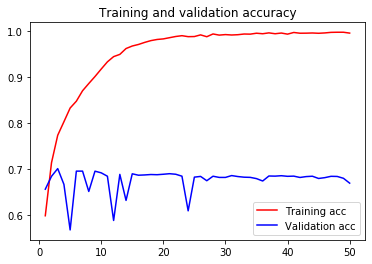

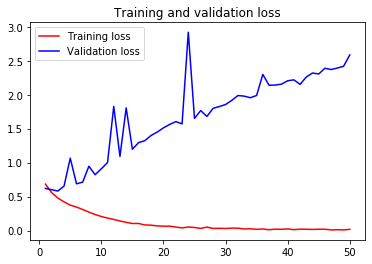

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')   
plt.legend()
plt.show()